<a href="https://colab.research.google.com/github/yeyevtushenko/IntroductionIAD/blob/main/%D0%92%D1%81%D1%82%D1%83%D0%BF_%D0%B4%D0%BE_%D1%96%D0%BD%D1%82%D0%B5%D0%BB%D0%B5%D0%BA%D1%82%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B0%D0%BD%D0%B0%D0%BB%D1%96%D0%B7%D1%83_%D0%B4%D0%B0%D0%BD%D0%B8%D1%85_%D0%91%D0%A1_25_%D0%84%D0%B2%D1%82%D1%83%D1%88%D0%B5%D0%BD%D0%BA%D0%BE_%D0%84%D0%B3%D0%BE%D1%80_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%BE%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Практична №3

##Теоретична частина

###1. Вступ до кластеризації

Перед розгляданням методу крабу давайте нагадаємо що таке кластериція. Отже:
- Кластеризація — це процес групування об'єктів (точок) на основі їхньої схожості. Об'єкти в одному кластері повинні бути схожими між собою більше, ніж з об'єктами з інших кластерів.

### 2. Опис алгоритму КРАБ

Алгоритм кластеризації методом КРАБ (кластеризація на основі ребер графа) базується на побудові незамкнутого зв'язного графа (ННШ), що з'єднує точки на основі відстаней між ними. Граф не містить петель, і його загальна довжина мінімальна.

### 3. Основні характеристики алгоритму

- Міра близькості (ρ): Чим менша відстань між точками всередині кластера, тим краще кластеризація.
- Міра віддаленості (d): Різні кластери повинні бути віддалені один від одного.
- Міра щільності (λ): Дослідник враховує зміни щільності точок і виділяє класи там, де щільність різко змінюється.

###4. Алгоритм роботи

Алгоритм КРАБ проходить кілька основних кроків:
1. Вибір початкової точки. Починаємо з однієї точки у вибірці.
2. Обчислення відстаней. Знаходимо відстані від цієї точки до інших точок вибірки.
3. З'єднання точок. Поступово з'єднуємо пари точок з мінімальною відстанню між ними, утворюючи ребра графа.
4. Завершення побудови графа. Процес триває, поки всі точки не будуть з'єднані між собою.
5. Розбиття на кластери. Розриваємо найбільші ребра графа, щоб виділити кілька кластерів.

###5. Міри якості кластеризації

- Внутрішня близькість: Оцінюється за середньою довжиною ребер всередині кластерів.
- Відстань між кластерами: Вимірюється як середня довжина ребер, що з'єднують різні кластери.

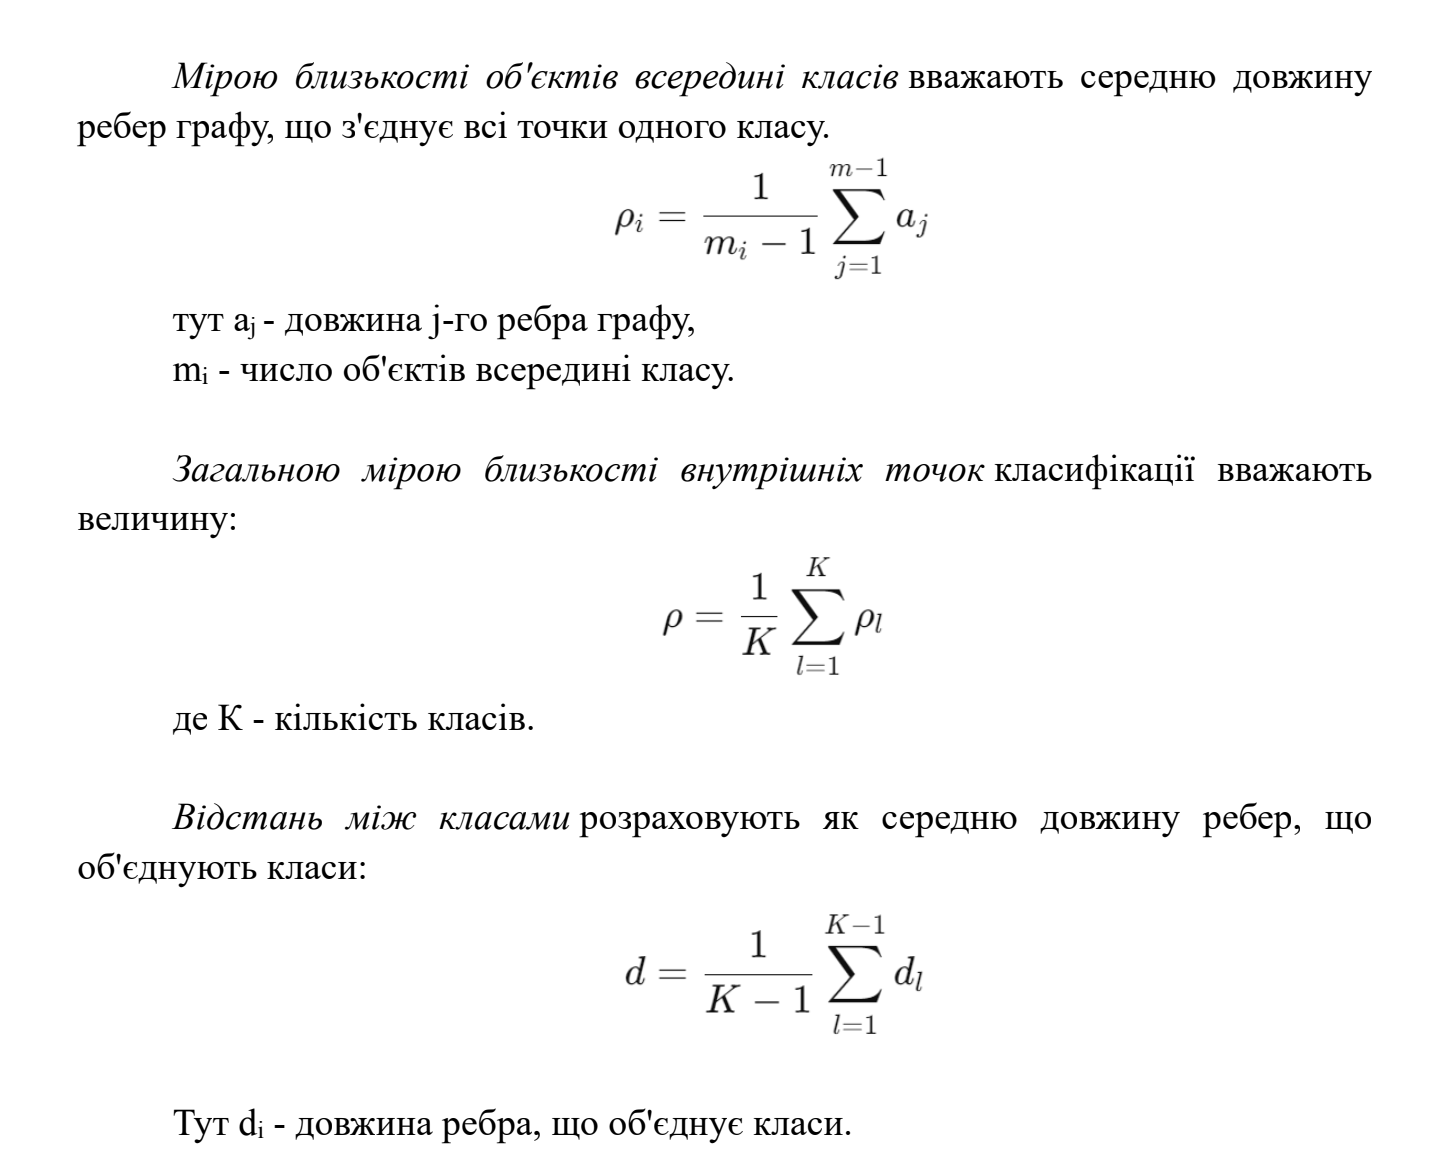

##Практична реалізація

### Імпорт модулів

In [42]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import single, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from openpyxl import Workbook

### Функція для вибору метрики

In [43]:
def select_metric():
    print("Виберіть метрику для обчислення відстаней:")
    print("1. Квадрат відстані Евкліда")
    print("2. Відстань Евкліда")
    print("3. Відстань Чебишева")
    print("4. Відстань Міньковського (p=3)")
    choice = int(input("Введіть номер метрики (1-4): "))

    if choice == 1:
        return 'sqeuclidean'  # Квадрат Евклідової відстані
    elif choice == 2:
        return 'euclidean'  # Евклідова відстань
    elif choice == 3:
        return 'chebyshev'  # Відстань Чебишева
    elif choice == 4:
        return 'minkowski'  # Відстань Міньковського
    else:
        print("Неправильний вибір. Використовується відстань Евкліда за замовчуванням.")
        return 'euclidean'

###Завантаження даних

In [44]:
data = pd.read_csv("https://raw.githubusercontent.com/yeyevtushenko/IntroductionIAD/refs/heads/Data/prostate.csv")

In [45]:
data.head()

,patno,stage,rx,dtime,status,age,wt,pf,hx,sbp,dbp,ekg,hg,sz,sg,ap,bm,sdate
0,1,3,0.2 mg estrogen,72,alive,75.0,76.0,normal activity,0,15,9,heart strain,13.798828,2.0,8.0,0.299988,0,2778
1,2,3,0.2 mg estrogen,1,dead - other ca,54.0,116.0,normal activity,0,13,7,heart block or conduction def,14.599609,42.0,NaN,0.699951,0,2820
2,3,3,5.0 mg estrogen,40,dead - cerebrovascular,69.0,102.0,normal activity,1,14,8,heart strain,13.398438,3.0,9.0,0.299988,0,2933
3,4,3,0.2 mg estrogen,20,dead - cerebrovascular,75.0,94.0,in bed < 50% daytime,1,14,7,benign,17.597656,4.0,8.0,0.899902,0,2999
4,5,3,placebo,65,alive,67.0,99.0,normal activity,0,17,10,normal,13.398438,34.0,8.0,0.500000,0,3002


### Вибір варіанту для виконання роботу

In [46]:
N = int(input("Enter your variant: "))
P = int(input("Enter your num of group: "))

start_index = N * 10 + P + 1
end_index = N * 10 + P + 30

# Вибір необхідної підмножини даних
subset_data = data.iloc[start_index:end_index][['ekg', 'age', 'bm']].dropna()

Enter your variant: 8
Enter your num of group: 25


### Перетворення текстових значень у стовпці 'Ekg' на числові

In [47]:
label_encoder = LabelEncoder()
subset_data['ekg'] = label_encoder.fit_transform(subset_data['ekg'])

### Нормалізація даних

In [48]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

### Вибір метрики

In [49]:
metric = select_metric()
if metric == 'minkowski':
    p = 3  # Параметр для метрики Міньковського
    distance_matrix = pdist(scaled_data, metric=metric, p=p)
else:
    distance_matrix = pdist(scaled_data, metric=metric)

Виберіть метрику для обчислення відстаней:
1. Квадрат відстані Евкліда
2. Відстань Евкліда
3. Відстань Чебишева
4. Відстань Міньковського (p=3)
Введіть номер метрики (1-4): 2


### Побудова мінімального остовного дерева (ННШ)

In [50]:
Z = single(distance_matrix)

### Автоматичне визначення max_d для розбиття на кластери

In [51]:
distances = Z[:, 2]
threshold = np.mean(distances) + 1.5 * np.std(distances)
max_d = np.max(distances[distances < threshold])

### Виконання кластеризації

In [52]:
subset_data['Cluster'] = fcluster(Z, max_d, criterion='distance')

### Покрокова таблиця

In [53]:
steps_table = pd.DataFrame(Z, columns=['Point 1', 'Point 2', 'Distance', 'Step'])

### Запис результатів до Excel-файлу

In [55]:
output_file = 'clustering_results_with_metrics.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    subset_data.to_excel(writer, sheet_name='Clustered Data', index=False)
    steps_table.to_excel(writer, sheet_name='Steps Table', index=False)

print(f"Файл збережено як {output_file}")

Файл збережено як clustering_results_with_metrics.xlsx


In [56]:
from google.colab import files
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Виведення результату

In [57]:
print(f"Результати збережені у файл: {output_file}")

Результати збережені у файл: clustering_results_with_metrics.xlsx


### Візуалізація кластеризації

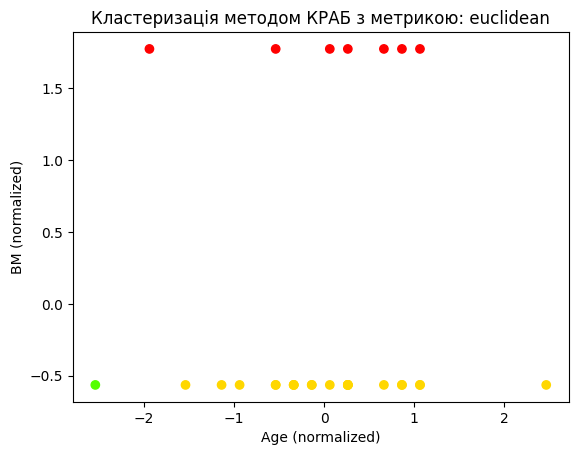

In [58]:
plt.scatter(scaled_data[:, 1], scaled_data[:, 2], c=subset_data['Cluster'], cmap='prism')
plt.title(f'Кластеризація методом КРАБ з метрикою: {metric}')
plt.xlabel('Age (normalized)')
plt.ylabel('BM (normalized)')
plt.show()

##Висновок

Метою цієї роботи було виконання кластеризації методом КРАБ (кластеризація на основі ребер графа) з використанням набору даних про пацієнтів з раком простати. Ми розглянули кілька ключових етапів і досягли наступних результатів:
1. Вибір даних: Ми вибрали підмножину даних для аналізу, зокрема стовпці Ekg, age, і bm, які представляють важливі характеристики пацієнтів, що впливають на кластеризацію. Дані були обмежені згідно з варіантом і номером групи.
2. Попередня обробка даних:
- Нормалізація: Оскільки кластеризація залежить від обчислення відстаней між точками, ми нормалізували дані для кожного параметра, щоб усі характеристики мали однаковий вплив на відстань.
- Перетворення текстових значень: Текстові значення в стовпці Ekg були перетворені в числові для того, щоб їх можна було використовувати в алгоритмі
3. Вибір метрики відстаней: Ми додали можливість вибору метрики для обчислення відстаней між точками (квадрат Евклідової відстані, Евклідова відстань, відстань Чебишева або Міньковського). Це дозволяє користувачу гнучко підходити до аналізу даних залежно від потреб.
4. Кластеризація методом КРАБ:
- Ми побудували мінімальний незамкнений шлях (ННШ) на основі обчислених відстаней між точками.
- Потім автоматично визначили поріг (max_d) для розриву найбільших ребер у графі, щоб сформувати кілька кластерів.
5. Аналіз результатів кластеризації:
- Було виявлено кілька кластерів. У графічній візуалізації ми побачили групи точок, які належать до різних кластерів, і одна або кілька точок, які можна вважати ізольованими або "шумом".
- Точки з високими значеннями BM (індекс маси тіла) формували окремий кластер, що відрізнявся від інших точок.
6. Збереження результатів: Результати кластеризації були збережені в Excel-файл, що містить два листи: один із даними та класифікацією, інший — із покроковою таблицею з'єднань точок під час побудови графа.
**ВАЖЛИВІ ВИСНОВКИ**
- Розподіл кластерів показав, що пацієнти можуть бути згруповані за певними характеристиками, такими як BM і age. Це дозволяє робити висновки про певні групи ризику серед пацієнтів.
- Гнучкість вибору метрики відстаней дозволила отримати різні варіанти кластеризації, що може бути корисно в залежності від специфіки задачі.
- Кластеризація методом КРАБ показала свою здатність знаходити класи довільної форми і виділяти окремі групи об'єктів, що можуть бути важливими для подальшого аналізу.